In [1]:
import sys, os
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

CURRENT_PATH = os.path.dirname(os.getcwd())
sys.path.insert(0, CURRENT_PATH)
sys.path.insert(0, CURRENT_PATH + '\\Modules')

In [2]:
norm_cdf = lambda x: stats.norm.cdf(x)
norm_icdf = lambda x: stats.norm.ppf(x)

vasicek_cdf = lambda x, rho, p: norm_cdf((np.sqrt(1-rho) * norm_icdf(x) - norm_icdf(p)) / np.sqrt(rho))
vasicek_pdf = lambda x, rho, p: np.sqrt((1-rho)/rho) * np.exp(0.5 * (norm_icdf(x)**2 - norm_icdf(vasicek_cdf(x, rho, p))**2))

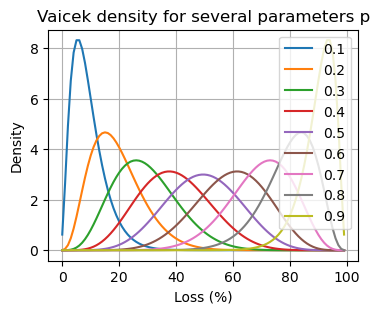

In [3]:
rho = 0.1

plt.figure(figsize=(4, 3))

for p in [i/100 for i in np.arange(10, 100, 10)]:
    plt.plot([vasicek_pdf(x, rho, p) for x in np.linspace(1e-2, 1-1e-2, 100)], label='{}'.format(p))

plt.xlabel('Loss (%)');
plt.ylabel('Density');
plt.legend();
plt.title('Vaicek density for several parameters p');
plt.grid();

# plt.savefig(CURRENT_PATH + '\\Output\\vasicek_density_p.png', format='png', dpi=300, bbox_inches = "tight")

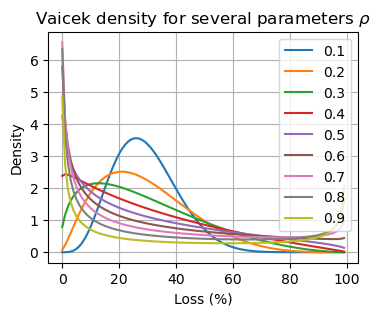

In [4]:
p = 0.3

plt.figure(figsize=(4, 3))

for rho in [i/100 for i in np.arange(10, 100, 10)]:
    plt.plot([vasicek_pdf(x, rho, p) for x in np.linspace(1e-2, 1-1e-2, 100)], label='{}'.format(rho))

plt.xlabel('Loss (%)');
plt.ylabel('Density');
plt.legend();
plt.title(r'Vaicek density for several parameters $\rho$');
plt.grid();

# plt.savefig(CURRENT_PATH + '\\Output\\vasicek_density_rho.png', format='png', dpi=300, bbox_inches = "tight")

In [5]:
lgd_function = lambda x, k: norm_cdf(norm_icdf(x) - k) / x

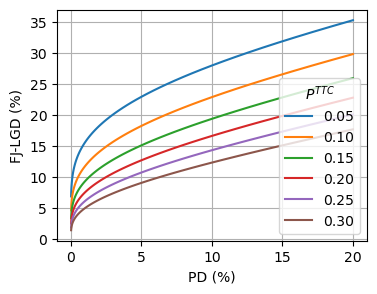

In [6]:
rho = 0.1
elgd = 0.25

x_ = np.exp(np.linspace(np.log(1e-4), np.log(0.2), 100))

plt.figure(figsize=(4, 3))

for p in np.linspace(0.05, 0.3, 6):
    el = p * elgd
    k = (norm_icdf(p) - norm_icdf(el)) / np.sqrt(1 - rho)
    y_ = [lgd_function(dr, k) for dr in x_]
    y_ = np.array(y_)

    plt.plot(x_*100, y_ * 100, label='{:.2f}'.format(p))

plt.legend(title=r'$P^{TTC}$')
plt.xlabel('PD (%)')
plt.ylabel('FJ-LGD (%)');
plt.grid()

# plt.savefig(CURRENT_PATH + '\\Output\\fj_lgd_dr.png', format='png', dpi=300, bbox_inches = "tight")

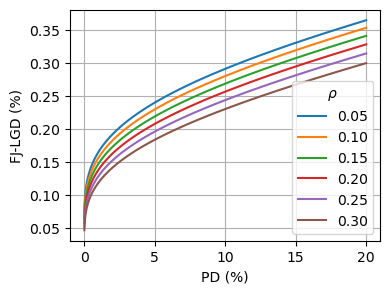

In [7]:
p = 0.05
elgd = 0.25

plt.figure(figsize=(4, 3))

for rho in np.linspace(0.05, 0.3, 6):
    el = p * elgd
    k = (norm_icdf(p) - norm_icdf(el)) / np.sqrt(1 - rho)
    y_ = [lgd_function(dr, k) for dr in x_]
    y_ = np.array(y_)

    plt.plot(x_*100, y_, label='{:.2f}'.format(rho))

plt.legend(title=r'$\rho$')
plt.xlabel('PD (%)')
plt.ylabel('FJ-LGD (%)');
plt.grid()

# plt.savefig(CURRENT_PATH + '\\Output\\fj_lgd_rho.png', format='png', dpi=300, bbox_inches = "tight")

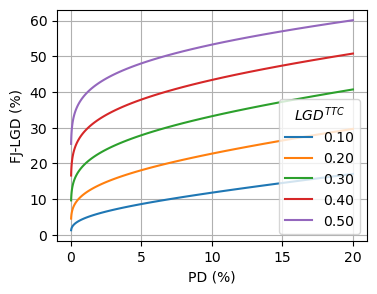

In [8]:
rho = 0.1
p = 0.05

plt.figure(figsize=(4, 3))

for elgd in np.linspace(0.1, 0.5, 5):
    el = p * elgd
    k = (norm_icdf(p) - norm_icdf(el)) / np.sqrt(1 - rho)
    y_ = [lgd_function(dr, k) for dr in x_]
    y_ = np.array(y_)

    plt.plot(x_*100, y_ * 100, label='{:.2f}'.format(elgd))

plt.legend(title=r'$LGD^{TTC}$')
plt.xlabel('PD (%)')
plt.ylabel('FJ-LGD (%)');
plt.grid()

# plt.savefig(CURRENT_PATH + '\\Output\\fj_lgd_lgd0.png', format='png', dpi=300, bbox_inches = "tight")

https://www.bportugal.pt/en/paper/relation-between-pd-and-lgd-application-corporate-loan-portfolio

In [9]:
def rho_basel(p, model="corporate"):
    if model == "retail":
        return 0.03 * (1 - np.exp(-35*p)) / (1 - np.exp(-35)) + 0.16 * (1 - (1 - np.exp(-35*p)) / (1 - np.exp(-35)))
    elif model == "corporate":
        return 0.12 * (1 - np.exp(-50*p)) / (1 - np.exp(-50)) + 0.24 * (1 - (1 - np.exp(-50*p)) / (1 - np.exp(-50)))

In [10]:
x_ = np.linspace(1e-3, 0.1, 30)
shocks = np.linspace(0.0, 0.1, 20)  # [10**float(i) for i in np.arange(-4, 0)]

p = 0.05
rho = rho_basel(p, model="corporate")
elgd = 0.25

el = p * elgd
k = (norm_icdf(p) - norm_icdf(el)) / np.sqrt(1 - rho)
y_ = [[lgd_function(dr + s, k) for s in shocks] for dr in x_]

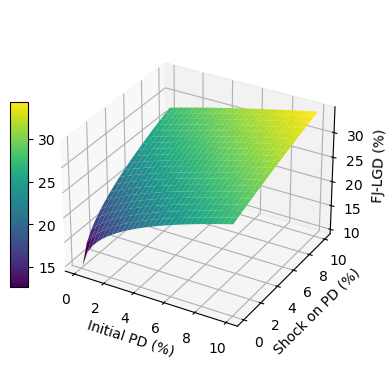

In [11]:
fig = plt.figure()
x = x_
y = shocks
X, Y = np.meshgrid(x, y)
Z = np.array(y_).T

ax = plt.axes(projection='3d')
surf = ax.plot_surface(100*X, 100*Y, 100*Z, rstride=1, cstride=1, cmap='viridis')
# ax.set_title('Effect of PD shock on LGD');

ax.set_xlabel('Initial PD (%)', rotation=0)
ax.set_ylabel('Shock on PD (%)', rotation=0)
ax.set_zlabel('FJ-LGD (%)', rotation=0)

axins1 = inset_axes(
    ax,
    width="5%",  # width: 50% of parent_bbox width
    height="50%",  # height: 5%
    loc="center left",
    borderpad=0
)

axins1.xaxis.set_ticks_position("default")
fig.colorbar(surf, cax=axins1)

ax.zaxis.set_major_locator(plt.MaxNLocator(6))

ax.set_box_aspect(aspect=None, zoom=0.83)

# plt.savefig(CURRENT_PATH + '\\Output\\surface_fj_lgd.png', format='png', dpi=300, bbox_inches = "tight")

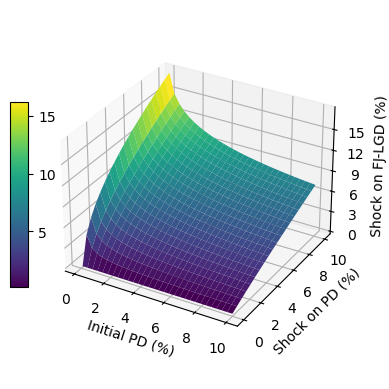

In [12]:
fig = plt.figure()
x = x_
y = shocks
X, Y = np.meshgrid(x, y)
Z = np.array(y_).T
Z = Z - Z[0]

ax = plt.axes(projection='3d')
surf = ax.plot_surface(100*X, 100*Y, 100*Z, rstride=1, cstride=1, cmap='viridis')
# ax.set_title('Effect of PD shock on LGD');

ax.set_xlabel('Initial PD (%)', rotation=0)
ax.set_ylabel('Shock on PD (%)', rotation=0)
ax.set_zlabel('Shock on FJ-LGD (%)', rotation=0)

axins1 = inset_axes(
    ax,
    width="5%",  # width: 50% of parent_bbox width
    height="50%",  # height: 5%
    loc="center left",
    borderpad=0
)

axins1.xaxis.set_ticks_position("default")
fig.colorbar(surf, cax=axins1)

ax.zaxis.set_major_locator(plt.MaxNLocator(6))

ax.set_box_aspect(aspect=None, zoom=0.83)

# plt.savefig(CURRENT_PATH + '\\Output\\surface_fj_lgd_shock.png', format='png', dpi=300, bbox_inches = "tight")

### Surface with rho function

In [13]:
x_ = np.linspace(1e-3, 0.1, 30)
shocks = np.linspace(0.0, 0.1, 20)  # [10**float(i) for i in np.arange(-4, 0)]

elgd = 0.25
p = 0.05

el = p * elgd
y_ = [[lgd_function(dr + s, (norm_icdf(p) - norm_icdf(el)) / np.sqrt(1 - rho_basel(dr + s))) for s in shocks] for dr in x_]

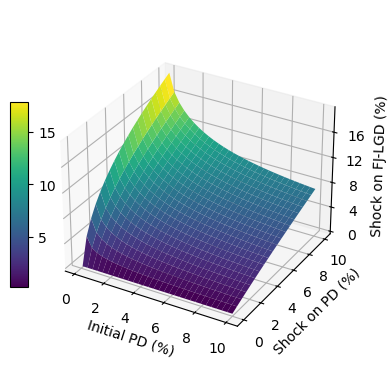

In [14]:
fig = plt.figure()
x = x_
y = shocks
X, Y = np.meshgrid(x, y)
Z = np.array(y_).T
Z = Z - Z[0]

ax = plt.axes(projection='3d')
surf = ax.plot_surface(100*X, 100*Y, 100*Z, rstride=1, cstride=1, cmap='viridis')
# ax.set_title('Effect of PD shock on LGD');

ax.set_xlabel('Initial PD (%)', rotation=0)
ax.set_ylabel('Shock on PD (%)', rotation=0)
ax.set_zlabel('Shock on FJ-LGD (%)', rotation=0)

axins1 = inset_axes(
    ax,
    width="5%",  # width: 50% of parent_bbox width
    height="50%",  # height: 5%
    loc="center left",
    borderpad=0
)

axins1.xaxis.set_ticks_position("default")
fig.colorbar(surf, cax=axins1)

ax.zaxis.set_major_locator(plt.MaxNLocator(6))

ax.set_box_aspect(aspect=None, zoom=0.83)

# plt.savefig(CURRENT_PATH + '\\Output\\surface_fj_lgd_shock.png', format='png', dpi=300, bbox_inches = "tight")